# Week One Part 2: Softmax
Softmax classifier is a generalization of logisitic regression that normalize a K-dimensional vector $z$ of arbitrary real values to a K-dimensional probabilistic scores.
Here, we are going to reuse Iris dataset. And we use the whole 3 types of iris plants and all these four attributes. petal length and width. Here are the data visually:

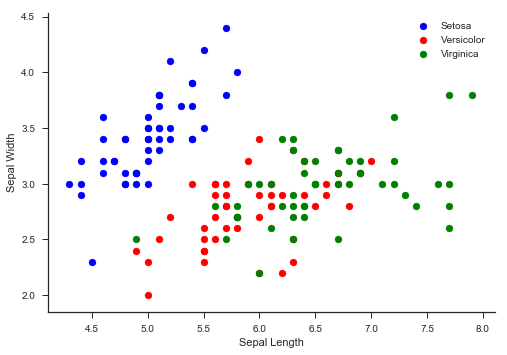

In [0]:
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='ticks', palette='Set2')
import pandas as pd
import numpy as np
import math
from __future__ import division

data = datasets.load_iris()
X = data.data# only get the first 2 features
y = data.target
setosa = plt.scatter(X[:50,0], X[:50,1], c='b')
versicolor = plt.scatter(X[50:100,0], X[50:100,1], c='r')
virginica = plt.scatter(X[100:,0], X[100:,1], c='g')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend((setosa, versicolor, virginica), ("Setosa", "Versicolor", "Virginica"))
sns.despine() # remove the abvoe axis

Assume we have one data sample $\mathbf{x}$, the output of softmax classifier is 

$$ P(y=j| \mathbf{x}) = \frac{e^{\mathbf{x}\mathbf{w}_j + b_j} }{\sum_{k=1}^{K}e^{\mathbf{x}\mathbf{w}_k+ b_k}}  $$
where $\mathbf{x} \in 1{\times}d$. 

Practical issues: Numeric Stability
When you’re writing code for computing the Softmax function in practice, the intermediate terms may be very large due to exponentials. Dividing large numbers can be numerically unstable, so it is important to use a normalization trick. Notice that if we multiply the top and bottom of the fraction by a constant $C$ and push it into the sum, we get the following (mathematically equivalent) expression:
$$\frac{e^{\mathbf{x}\mathbf{w}_j+ b_j}}{\sum_{k=1}^{K}e^{\mathbf{x}\mathbf{w}_k+ b_k}}=\frac{Ce^{\mathbf{x}\mathbf{w}_j+ b_j}}{C\sum_{k=1}^{K}e^{\mathbf{x}\mathbf{w}_k+ b_k}}=\frac{e^{\mathbf{x}\mathbf{w}_j+ b_j+logC}}{\sum_{k=1}^{K}e^{\mathbf{x}\mathbf{w}_k+ b_k+logC}}$$

Here, $logC=-max_j{\mathbf{x}\mathbf{w}_j+ b_j}$. which make the highet value after linear transformation as zero.

Similar to the logistic regression model, 
the **loss function** is set to be cross-entropy error:
1. LR: $−(ylog(p)+(1−y)log(1−p))$
2. Softmax: $-\sum_{k=1}^{K}y_klog(P(y=k| \mathbf{x}))$

Here, $y_k$ is the binary indicator if class label k is the correct classification.

In [0]:
def softmax(W, b, X):
    """ the implmentation of softmax function
    - W, b are the model parameters
    - X is the feature matrix
    """
    z = np.dot(X,W) + b
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

def cost_func(W, b, X, y):
    """the implmentation of cost function for softmax classifier
    - beta is the model parameters
    - x is the feature matrix （num sample times the number of features)
    - y is the label vector (num sample)
    """
    num_examples = X.shape[0]
    probs = softmax(W, b, X)
    correct_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(correct_logprobs)/num_examples
    return np.mean(data_loss)

##### Model Parameters

$$ \mathbf{z} = \mathbf{x}\mathbf{W} + \mathbf{b}$$

In [0]:
W = 0.01 * np.random.randn(4,3)
b = 0.01 * np.random.randn(1,3) #np.zeros((1,3))

In [0]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [0]:
softmax(W, b, X[:2,:])

array([[ 0.33529497,  0.33201049,  0.33269454],
       [ 0.33274942,  0.33175544,  0.33549514]])

In [0]:
cost_func(W,b,X,y)

1.0945094319038682

###### some equations
$$\frac{d}{dx}log(x) = \frac{1}{x}$$
$$\frac{d}{dx}e^{x} = e^{x}$$
###### quotient rule
$$f^{,}(x)=\frac{g^{,}(x)h(x)-g(x)h^{,}(x)}{h(x)^2}$$
when $f(x)=\frac{g(x)}{h(x)}$
#### Gradient Computation

The loss function:
$$l(W,b) = - log\frac{e^{z_i}}{\sum_{k=1}^{K}e^{z_j}} 
         = - logp_i$$
where $z_j=xw_j+b$
The key issue to get $\frac{dl}{dz_j}=\frac{dl}{dp_i}\frac{dp_i}{dz_j}$

The first part is simple:
$$\frac{dl}{dp_i} = -\frac{1}{p_i} $$

The second part is $\frac{dp_i}{dz_j}$. there are two cases:

if $i=j$, 
$$\frac{dp_i}{dz_j} = \frac{e^{z_i}\sum-e^{z_i}e^{z_j}}{\sum^2} = \frac{e^{z_i}(\sum - e^{z_j})}{\sum^2} = p_i(1-p_j) $$

$$ \frac{dl}{dz_j} = p_j - 1 $$
if $i!=j$
$$\frac{dp_i}{dz_j} = \frac{0-e^{z_i}e^{z_j}}{\sum^2} = -p_ip_j $$

$$ \frac{dl}{dz_j} = p_j $$

$\frac{dl}{dW}$ and $\frac{dl}{db}$ then can be computed

In [0]:
def softmax_gradient(W,b, X,y):
    num_examples = X.shape[0]
    #z_scores = np.dot(X,W) + b
    probs = softmax(W, b, X)    
    probs[range(num_examples),y] -= 1 #if i == j, minus 1
    probs /= num_examples
    dW = np.dot(X.T, probs)
    db = np.sum(probs, axis=0, keepdims=True)
    return dW, db

In [0]:
def grad_desc(W,b, X, y, lr=.001, converge_change=.00005):
    #normalize
    #X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    #setup cost iter
    cost_iter = []
    cost = cost_func(W,b, X, y)
    cost_iter.append([0, cost])
    change_cost = 1
    i = 1
    while(change_cost > converge_change):
        old_cost = cost
        dW, db = softmax_gradient(W,b,X,y)
        W = W - lr * dW
        b = b - lr * db
        cost = cost_func(W, b, X, y)
        cost_iter.append([i, cost])
        change_cost = old_cost - cost
        i+=1
    return W, b, np.array(cost_iter)

def pred_values(W, b, X,hard=True):
    z_scores = np.dot(X,W) + b
    probs = softmax(z_scores)
    if hard:
        predicted_class = np.argmax(probs, axis=1)
        return predicted_class
    return probs

In [0]:
W = 0.001 * np.random.randn(4,3)
b = np.zeros((1,3))
W, b, cost_iter = grad_desc(W,b, X, y, lr=0.01)

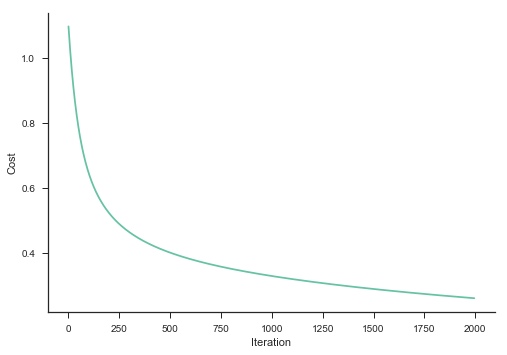

In [0]:
plt.plot(cost_iter[:,0], cost_iter[:,1])
plt.ylabel("Cost")
plt.xlabel("Iteration")
sns.despine()

In [0]:
hh = pred_values(W,b,X,y)

In [0]:
np.sum(hh == y)

138

In [0]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
logreg.fit(X, y)
sum(y == logreg.predict(X))

146